# Introdução:

* Este projeto de modelagem tem como objetivo analisar e prever os gastos senatoriais ao longo do tempo, utilizando técnicas de aprendizado de máquina e análise de séries temporais. O conjunto de dados consiste em informações históricas de reembolsos realizados por senadores, incluindo datas, valores e outras variáveis relevantes.

* Neste contexto, exploramos inicialmente um modelo baseline, que se baseia na média dos últimos três meses, como referência para comparação com modelos mais avançados. Em seguida, aplicamos uma regressão linear para capturar possíveis tendências e relacionamentos lineares nos dados. Além disso, utilizamos o modelo ARIMA (AutoRegressive Integrated Moving Average) para capturar padrões temporais e sazonais nos gastos senatoriais.

* Avaliamos o desempenho de cada modelo por meio de métricas como Erro Médio Absoluto (MAE), Erro Quadrático Médio (MSE) e Coeficiente de Determinação (R²), buscando entender como cada abordagem se comporta na previsão dos gastos e quais insights podemos extrair para entender melhor os padrões de gastos ao longo do tempo.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression


In [22]:
# Carregar o dataset
file_path = '/content/dataset_ceaps_forecasting (1).csv'  # Ajuste o nome do arquivo conforme necessário
ceaps_data = pd.read_csv(file_path)


In [23]:
# Exibir informações gerais e as primeiras linhas do dataset
ceaps_data.info()
ceaps_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      1461 non-null   object 
 1   y       1461 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.0+ KB


,ds,y
0,2018-01-01,13062.46
1,2018-01-02,61972.66
2,2018-01-03,54424.44
3,2018-01-04,21775.57
4,2018-01-05,41703.32


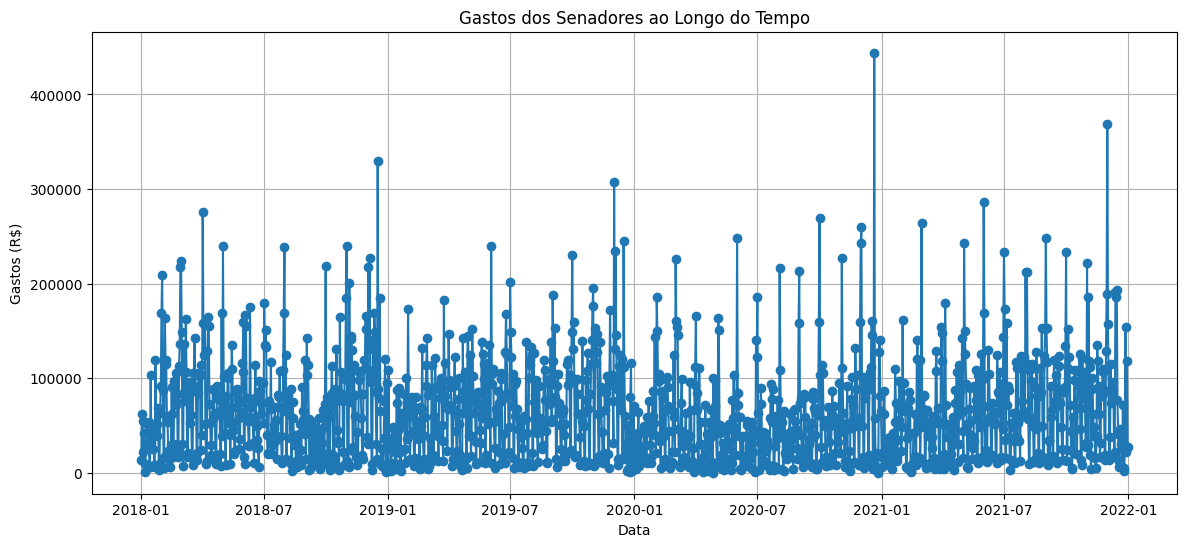

In [24]:
# Convertendo 'ds' para datetime
ceaps_data['ds'] = pd.to_datetime(ceaps_data['ds'])

# Plotando a série temporal de gastos
plt.figure(figsize=(14, 6))
plt.plot(ceaps_data['ds'], ceaps_data['y'], marker='o', linestyle='-')
plt.title('Gastos dos Senadores ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Gastos (R$)')
plt.grid(True)
plt.show()

In [25]:
# Resumo estatístico dos gastos
ceaps_data.describe()

# Verificando valores ausentes
missing_values = ceaps_data.isnull().sum()


In [26]:
# Verificando valores ausentes
missing_values = ceaps_data.isnull().sum()

# Realizando o teste de Dickey-Fuller Aumentado (ADF) para testar a estacionariedade
adf_test = adfuller(ceaps_data['y'])

# Estruturando o resultado do teste ADF
adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Number of Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4],
}

missing_values, adf_result

(ds    0
 y     0
 dtype: int64,
 {'Test Statistic': -7.526436598495929,
  'p-value': 3.6742361407926827e-11,
  'Number of Lags Used': 21,
  'Number of Observations Used': 1439,
  'Critical Values': {'1%': -3.4349024693573584,
   '5%': -2.8635506057382325,
   '10%': -2.5678404322793846}})

In [27]:
# Calcular a média dos últimos três meses para o modelo baseline
# Os últimos três meses no dataset são Outubro, Novembro e Dezembro de 2021
last_three_months = ceaps_data[ceaps_data['ds'] >= '2021-10-01']
baseline_prediction = last_three_months['y'].mean()

baseline_prediction

75787.79913043477

In [28]:
# Verificar os tipos de dados de cada coluna no DataFrame
ceaps_data.dtypes


ds    datetime64[ns]
y            float64
dtype: object

In [29]:

# Verificar valores ausentes no conjunto de dados
missing_values = ceaps_data.isnull().sum()
missing_values

# Calcular estatísticas descritivas básicas para variáveis numéricas
desc_stats = ceaps_data.describe()
desc_stats

,ds,y
count,1461,1461.000000
mean,2020-01-01 00:00:00,63876.044497
min,2018-01-01 00:00:00,100.000000
25%,2019-01-01 00:00:00,19735.990000
50%,2020-01-01 00:00:00,53764.030000
75%,2020-12-31 00:00:00,91485.640000
max,2021-12-31 00:00:00,444152.910000
std,NaN,53285.501861


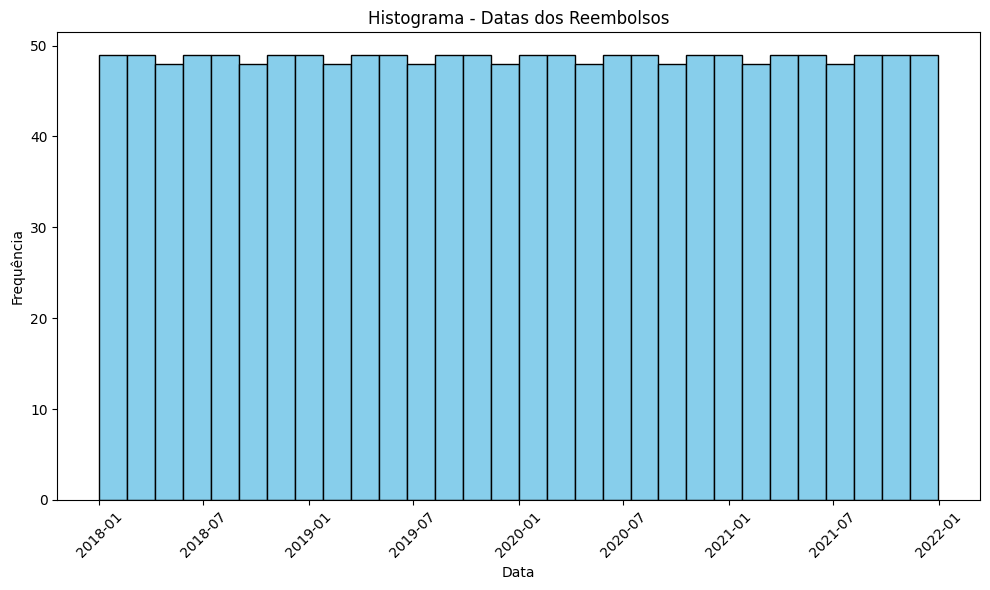

In [30]:
# Histograma para a variável "ds" (datas dos reembolsos)
plt.figure(figsize=(10, 6))
plt.hist(ceaps_data['ds'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Data')
plt.ylabel('Frequência')
plt.title('Histograma - Datas dos Reembolsos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

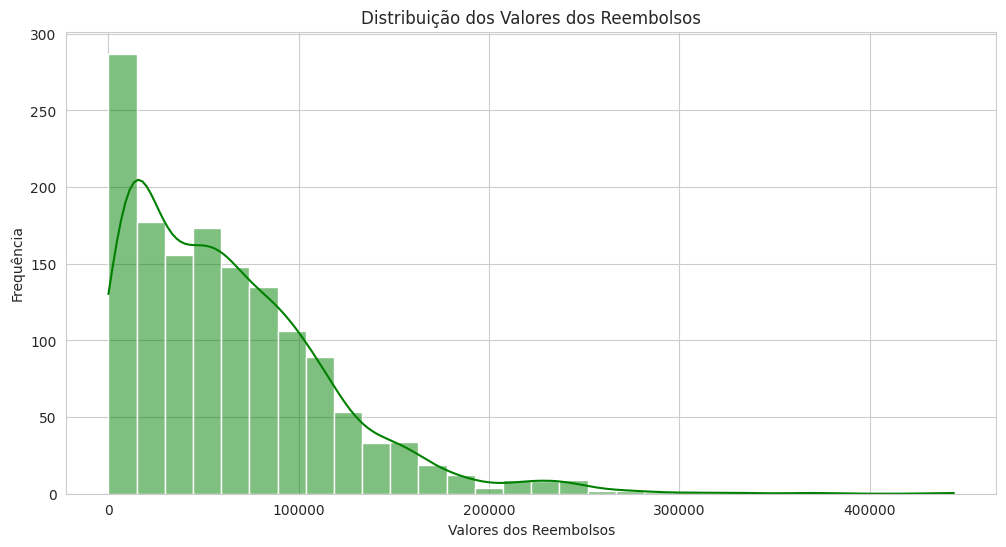

In [31]:
# Configurações visuais
sns.set_style('whitegrid')

# Histograma para os valores dos reembolsos
plt.figure(figsize=(12, 6))
sns.histplot(ceaps_data['y'], bins=30, kde=True, color='green')
plt.xlabel('Valores dos Reembolsos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Valores dos Reembolsos')
plt.show()

In [32]:
# Realiza o teste ADF na série temporal dos valores dos reembolsos
result = adfuller(ceaps_data['y'])

# Extrai os resultados do teste
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

In [33]:
# Imprime os resultados do teste
print(f'Teste ADF - Estatística: {adf_statistic}')
print(f'Teste ADF - Valor-p (p-value): {p_value}')
print('Valores Críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

Teste ADF - Estatística: -7.526436598495929
Teste ADF - Valor-p (p-value): 3.6742361407926827e-11
Valores Críticos:
   1%: -3.4349024693573584
   5%: -2.8635506057382325
   10%: -2.5678404322793846


In [34]:
# Verifica se a série é estacionária com base no valor-p
if p_value < 0.05:
    print('A série temporal é estacionária.')
else:
    print('A série temporal não é estacionária.')


A série temporal é estacionária.


In [35]:
# Extrair componentes de data
ceaps_data['ano'] = ceaps_data['ds'].dt.year
ceaps_data['mes'] = ceaps_data['ds'].dt.month
ceaps_data['dia_semana'] = ceaps_data['ds'].dt.day_name()

# Gerar variáveis de lag
ceaps_data['lag_1'] = ceaps_data['y'].shift(1)
ceaps_data['lag_7'] = ceaps_data['y'].shift(7)

In [36]:
# Gerar janelas móveis
ceaps_data['rolling_mean_7'] = ceaps_data['y'].rolling(window=7).mean()
ceaps_data['rolling_std_7'] = ceaps_data['y'].rolling(window=7).std()


In [37]:
# Verificar valores nulos
null_values = ceaps_data.isnull().sum()

# Exibir os valores nulos por coluna
print(null_values)

ds                0
y                 0
ano               0
mes               0
dia_semana        0
lag_1             1
lag_7             7
rolling_mean_7    6
rolling_std_7     6
dtype: int64


In [38]:
# Remover linhas com valores nulos
ceaps_data_cleaned = ceaps_data.dropna()

# Verificar se os valores nulos foram removidos
ceaps_data_cleaned.isnull().sum()

ds                0
y                 0
ano               0
mes               0
dia_semana        0
lag_1             0
lag_7             0
rolling_mean_7    0
rolling_std_7     0
dtype: int64

In [39]:
# Visualizar o resultado
print(ceaps_data_cleaned.head(10))


           ds          y   ano  mes dia_semana      lag_1     lag_7  \
7  2018-01-08   29365.72  2018    1     Monday     988.73  13062.46   
8  2018-01-09   31053.81  2018    1    Tuesday   29365.72  61972.66   
9  2018-01-10   51899.11  2018    1  Wednesday   31053.81  54424.44   
10 2018-01-11   32412.29  2018    1   Thursday   51899.11  21775.57   
11 2018-01-12   53804.58  2018    1     Friday   32412.29  41703.32   
12 2018-01-13    6643.83  2018    1   Saturday   53804.58   9299.75   
13 2018-01-14    6180.27  2018    1     Sunday    6643.83    988.73   
14 2018-01-15  103554.74  2018    1     Monday    6180.27  29365.72   
15 2018-01-16   31897.49  2018    1    Tuesday  103554.74  31053.81   
16 2018-01-17   40659.59  2018    1  Wednesday   31897.49  51899.11   

    rolling_mean_7  rolling_std_7  
7     31361.455714   22660.518975  
8     26944.477143   18291.508236  
9     26583.715714   17673.661864  
10    28103.247143   17648.612433  
11    29831.998571   19678.743113  
12

In [40]:
# Criar uma cópia explícita do DataFrame para evitar avisos de cópia de slice
ceaps_data_cleaned = ceaps_data.copy()


In [41]:
# Converter a coluna 'ds' para o tipo datetime
ceaps_data_cleaned['ds'] = pd.to_datetime(ceaps_data_cleaned['ds'])


In [42]:

# Ordenar o DataFrame pela coluna 'ds' em ordem crescente
ceaps_data_cleaned.sort_values('ds', inplace=True)


In [43]:
# Definir a coluna 'ds' como índice para facilitar a aplicação da função rolling
ceaps_data_cleaned.set_index('ds', inplace=True)


In [44]:
# Calcular a média dos últimos três meses usando a função rolling
media_ultimos_tres_meses = ceaps_data_cleaned['y'].rolling(window=90).mean()

# Exibir as últimas linhas para verificar o resultado
print(media_ultimos_tres_meses.tail())


ds
2021-12-27    76393.932556
2021-12-28    77099.548556
2021-12-29    75854.583889
2021-12-30    74572.842444
2021-12-31    74731.080222
Name: y, dtype: float64


In [45]:
# Verificar valores nulos
print(ceaps_data_cleaned.isnull().sum())


y                 0
ano               0
mes               0
dia_semana        0
lag_1             1
lag_7             7
rolling_mean_7    6
rolling_std_7     6
dtype: int64


In [46]:
# Remover linhas com valores nulos
ceaps_data_cleaned = ceaps_data.dropna(subset=['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7'])


In [47]:
# Verificar novamente se os valores nulos foram removidos
print(ceaps_data_cleaned.isnull().sum())

# Calcular estatísticas descritivas para a variável 'y'
desc_stats = ceaps_data_cleaned['y'].describe()

# Imprimir as estatísticas descritivas
print(desc_stats)

ds                0
y                 0
ano               0
mes               0
dia_semana        0
lag_1             0
lag_7             0
rolling_mean_7    0
rolling_std_7     0
dtype: int64
count      1454.000000
mean      64043.792352
std       53336.895716
min         100.000000
25%       19805.657500
50%       53796.990000
75%       91713.662500
max      444152.910000
Name: y, dtype: float64


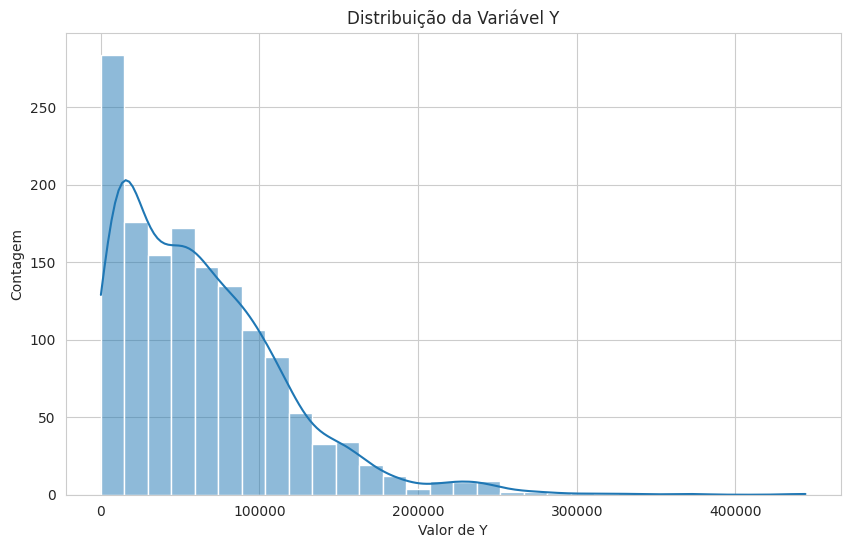

In [48]:
# Histograma para a variável 'y'
plt.figure(figsize=(10, 6))
sns.histplot(data=ceaps_data_cleaned, x='y', bins=30, kde=True)
plt.title('Distribuição da Variável Y')
plt.xlabel('Valor de Y')
plt.ylabel('Contagem')
plt.show()


In [49]:
# Configurações visuais
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

Text(0, 0.5, 'Frequência')

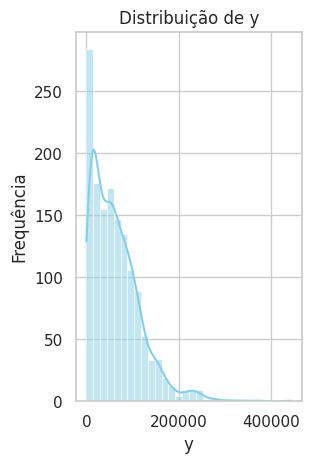

In [50]:
# Histograma da variável 'y'
plt.subplot(1, 2, 1)
sns.histplot(ceaps_data_cleaned['y'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição de y')
plt.xlabel('y')
plt.ylabel('Frequência')

<ipython-input-51-ca297ad0c5f7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dia_semana', data=ceaps_data_cleaned, palette='pastel', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


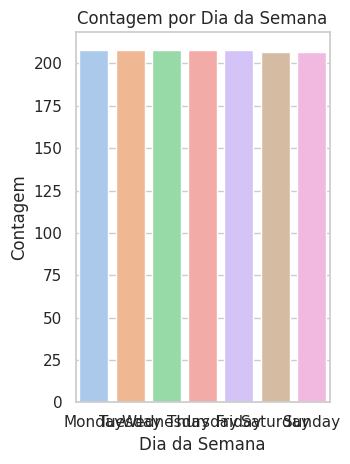

In [51]:
# Gráfico de barras da variável 'dia_semana'
plt.subplot(1, 2, 2)
sns.countplot(x='dia_semana', data=ceaps_data_cleaned, palette='pastel', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Contagem por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

In [52]:
# Extrair componentes de data
ceaps_data_cleaned['ano'] = ceaps_data_cleaned['ds'].dt.year
ceaps_data_cleaned['mes'] = ceaps_data_cleaned['ds'].dt.month
ceaps_data_cleaned['dia_semana'] = ceaps_data_cleaned['ds'].dt.day_name()

# Criar variáveis de lag
ceaps_data_cleaned['lag_1'] = ceaps_data_cleaned['y'].shift(1)
ceaps_data_cleaned['lag_7'] = ceaps_data_cleaned['y'].shift(7)


<ipython-input-52-c3101ccdea74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceaps_data_cleaned['ano'] = ceaps_data_cleaned['ds'].dt.year
<ipython-input-52-c3101ccdea74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceaps_data_cleaned['mes'] = ceaps_data_cleaned['ds'].dt.month
<ipython-input-52-c3101ccdea74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [53]:
# Criar janelas móveis
ceaps_data_cleaned['rolling_mean_7'] = ceaps_data_cleaned['y'].rolling(window=7).mean()
ceaps_data_cleaned['rolling_std_7'] = ceaps_data_cleaned['y'].rolling(window=7).std()

# Remover linhas com valores nulos resultantes das operações acima
ceaps_data_cleaned.dropna(inplace=True)

# Visualizar as primeiras linhas do DataFrame após as transformações
print(ceaps_data_cleaned.head())

           ds          y   ano  mes dia_semana      lag_1     lag_7  \
14 2018-01-15  103554.74  2018    1     Monday    6180.27  29365.72   
15 2018-01-16   31897.49  2018    1    Tuesday  103554.74  31053.81   
16 2018-01-17   40659.59  2018    1  Wednesday   31897.49  51899.11   
17 2018-01-18   24732.86  2018    1   Thursday   40659.59  32412.29   
18 2018-01-19   49513.79  2018    1     Friday   24732.86  53804.58   

    rolling_mean_7  rolling_std_7  
14    40792.661429   33568.283424  
15    40913.187143   33528.980188  
16    39307.541429   33182.531042  
17    38210.480000   33573.139656  
18    37597.510000   33278.854584  


<ipython-input-53-e5546131dc74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceaps_data_cleaned['rolling_mean_7'] = ceaps_data_cleaned['y'].rolling(window=7).mean()
<ipython-input-53-e5546131dc74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceaps_data_cleaned['rolling_std_7'] = ceaps_data_cleaned['y'].rolling(window=7).std()
<ipython-input-53-e5546131dc74>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

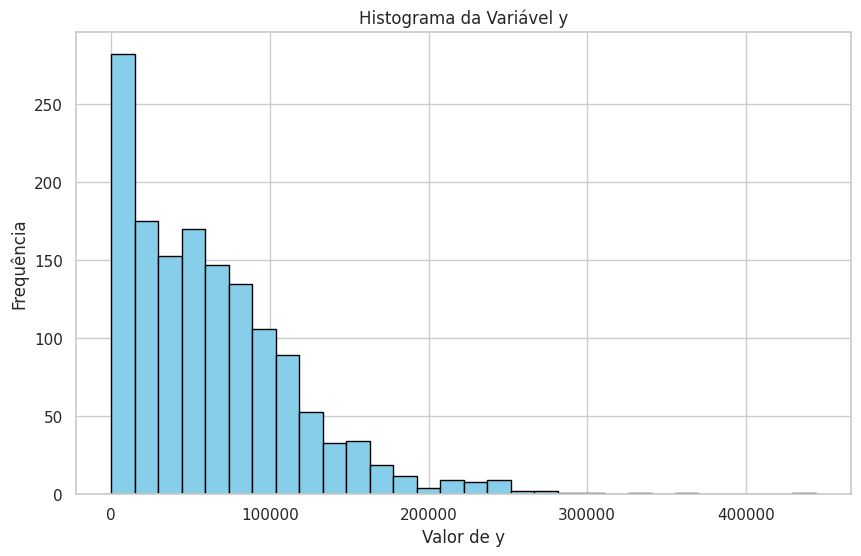

In [54]:
# Visualizar histograma da variável 'y'
plt.figure(figsize=(10, 6))
ceaps_data_cleaned['y'].hist(bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Valor de y')
plt.ylabel('Frequência')
plt.title('Histograma da Variável y')
plt.show()


In [55]:
# Filtrar os dados para os últimos cinco dias de 2021
last_five_days_2021 = ceaps_data_cleaned[(ceaps_data_cleaned['ano'] == 2021) & (ceaps_data_cleaned['ds'].dt.month == 12) & (ceaps_data_cleaned['ds'].dt.day >= 27)]

# Calcular a média da variável 'y' nos últimos três meses
last_three_months_mean = last_five_days_2021['y'].mean()
print("Média dos últimos três meses:", last_three_months_mean)

Média dos últimos três meses: 70232.082


In [56]:
# Definir a data de corte entre treino e teste
data_corte = '2021-01-01'

# Separar os dados de treino e teste
dados_treino = ceaps_data_cleaned[ceaps_data_cleaned['ds'] < data_corte]
dados_teste = ceaps_data_cleaned[ceaps_data_cleaned['ds'] >= data_corte]

# Verificar o tamanho dos conjuntos
print('Dados de Treino:', dados_treino.shape)
print('Dados de Teste:', dados_teste.shape)

Dados de Treino: (1082, 9)
Dados de Teste: (365, 9)


In [57]:
# Calcular a média dos últimos três meses do conjunto de treino
media_ultimos_tres_meses = dados_treino['y'].tail(90).mean()


In [58]:
# Aplicar a média como previsão para todos os dados do conjunto de teste
dados_teste['previsao_baseline'] = media_ultimos_tres_meses


<ipython-input-58-072b68ee3c58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_teste['previsao_baseline'] = media_ultimos_tres_meses


In [59]:
# Calcular métricas de avaliação
mae_baseline = mean_absolute_error(dados_teste['y'], dados_teste['previsao_baseline'])
mse_baseline = mean_squared_error(dados_teste['y'], dados_teste['previsao_baseline'])
r2_baseline = r2_score(dados_teste['y'], dados_teste['previsao_baseline'])


In [60]:
# Visualizar as métricas
print('Erro Médio Absoluto (MAE) do Baseline:', mae_baseline)
print('Erro Quadrático Médio (MSE) do Baseline:', mse_baseline)
print('Coeficiente de Determinação (R²) do Baseline:', r2_baseline)


Erro Médio Absoluto (MAE) do Baseline: 41865.75277138509
Erro Quadrático Médio (MSE) do Baseline: 3001189636.0502496
Coeficiente de Determinação (R²) do Baseline: -0.000704469700093302


In [61]:
# Verificar o tamanho dos dados de treino
print('Dados de Treino:', dados_treino.shape)


Dados de Treino: (1082, 9)


In [62]:
# Preparar as features e o target
X_treino = dados_treino[['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7']]
y_treino = dados_treino['y']

X_teste = dados_teste[['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7']]
y_teste = dados_teste['y']

In [63]:
# Criar o modelo de regressão linear
modelo_reg_linear = LinearRegression()

# Ajustar o modelo aos dados de treino
modelo_reg_linear.fit(X_treino, y_treino)

LinearRegression()

In [64]:
# Fazer previsões com o modelo ajustado
previsoes_reg_linear = modelo_reg_linear.predict(X_teste)


In [65]:
# Avaliar o desempenho do modelo
mae_reg_linear = mean_absolute_error(y_teste, previsoes_reg_linear)
mse_reg_linear = mean_squared_error(y_teste, previsoes_reg_linear)
r2_reg_linear = r2_score(y_teste, previsoes_reg_linear)

print('Erro Médio Absoluto (MAE) da Regressão Linear:', mae_reg_linear)
print('Erro Quadrático Médio (MSE) da Regressão Linear:', mse_reg_linear)
print('Coeficiente de Determinação (R²) da Regressão Linear:', r2_reg_linear)

Erro Médio Absoluto (MAE) da Regressão Linear: 34561.33905046123
Erro Quadrático Médio (MSE) da Regressão Linear: 2190931565.9161015
Coeficiente de Determinação (R²) da Regressão Linear: 0.2694646867751085


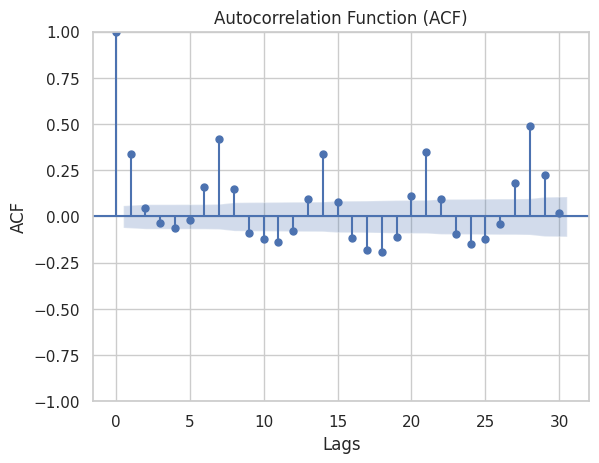

In [66]:
# Plot ACF
plot_acf(dados_treino['y'], lags=30)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
plt.show()

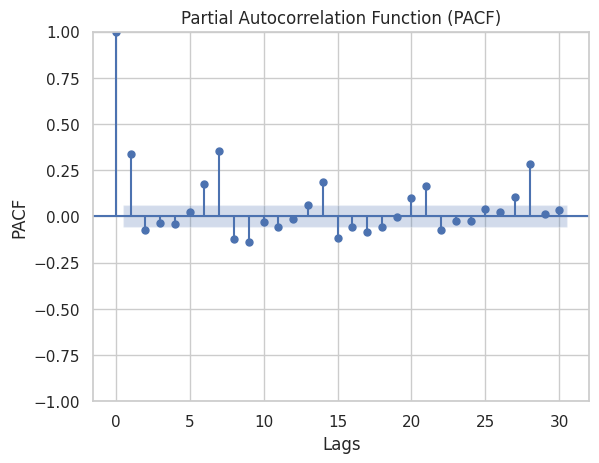

In [67]:
# Plot PACF
plot_pacf(dados_treino['y'], lags=30)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [68]:
# Definir os valores para p, d e q a serem testados
p_values = range(0, 3)  # Exemplo de valores, ajuste conforme necessário
d_values = range(0, 3)
q_values = range(0, 3)

In [69]:
# Criar lista de todas as combinações de p, d, q
combinations = list(product(p_values, d_values, q_values))

# Armazenar as métricas para cada combinação
best_score = float('inf')
best_params = None

In [70]:
# Loop para ajustar e avaliar o modelo para cada combinação
for params in combinations:
    try:
        model = sm.tsa.ARIMA(dados_treino['y'], order=params)
        result = model.fit()
        if result.aic < best_score:
            best_score = result.aic
            best_params = params
    except:
        continue

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

In [77]:
# Exibir os melhores parâmetros encontrados
print('Melhores Parâmetros ARIMA:', best_params)


Melhores Parâmetros ARIMA: (2, 0, 2)


In [85]:
# Ajustar o modelo ARIMA com os melhores parâmetros aos dados de treino
modelo_arima = ARIMA(dados_treino['y'], order=best_params)
ajuste_arima = modelo_arima.fit()

# Fazer previsões com o modelo ajustado
previsoes_arima = ajuste_arima.forecast(steps=len(dados_teste))

# Avaliar o desempenho do modelo ARIMA
mae_arima = mean_absolute_error(y_teste, previsoes_arima)
mse_arima = mean_squared_error(y_teste, previsoes_arima)
r2_arima = r2_score(y_teste, previsoes_arima)

print('Erro Médio Absoluto (MAE) do ARIMA:', mae_arima)
print('Erro Quadrático Médio (MSE) do ARIMA:', mse_arima)
print('Coeficiente de Determinação (R²) do ARIMA:', r2_arima)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Erro Médio Absoluto (MAE) do ARIMA: 35389.911218585636
Erro Quadrático Médio (MSE) do ARIMA: 2395941691.0066795
Coeficiente de Determinação (R²) do ARIMA: 0.2011069442160901


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


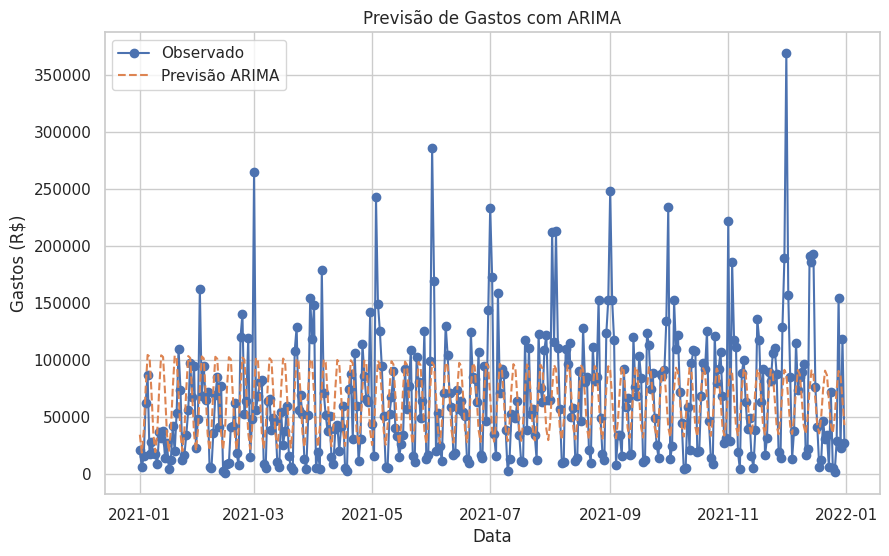

In [86]:
# Plot das previsões ARIMA
plt.figure(figsize=(10, 6))
plt.plot(dados_teste['ds'], dados_teste['y'], label='Observado', marker='o')
plt.plot(dados_teste['ds'], previsoes_arima, label='Previsão ARIMA', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Gastos (R$)')
plt.title('Previsão de Gastos com ARIMA')
plt.legend()
plt.grid(True)
plt.show()


In [87]:
# Exibir os resultados finais
print('Resultados Finais:')
print('Erro Médio Absoluto (MAE) do Baseline:', mae_baseline)
print('Erro Quadrático Médio (MSE) do Baseline:', mse_baseline)
print('Coeficiente de Determinação (R²) do Baseline:', r2_baseline)
print('Erro Médio Absoluto (MAE) da Regressão Linear:', mae_reg_linear)
print('Erro Quadrático Médio (MSE) da Regressão Linear:', mse_reg_linear)
print('Coeficiente de Determinação (R²) da Regressão Linear:', r2_reg_linear)
print('Erro Médio Absoluto (MAE) do ARIMA:', mae_arima)
print('Erro Quadrático Médio (MSE) do ARIMA:', mse_arima)
print('Coeficiente de Determinação (R²) do ARIMA:', r2_arima)

Resultados Finais:
Erro Médio Absoluto (MAE) do Baseline: 41865.75277138509
Erro Quadrático Médio (MSE) do Baseline: 3001189636.0502496
Coeficiente de Determinação (R²) do Baseline: -0.000704469700093302
Erro Médio Absoluto (MAE) da Regressão Linear: 34561.33905046123
Erro Quadrático Médio (MSE) da Regressão Linear: 2190931565.9161015
Coeficiente de Determinação (R²) da Regressão Linear: 0.2694646867751085
Erro Médio Absoluto (MAE) do ARIMA: 35389.911218585636
Erro Quadrático Médio (MSE) do ARIMA: 2395941691.0066795
Coeficiente de Determinação (R²) do ARIMA: 0.2011069442160901
